# Calculate Equivalent Widths (EWs) Using A Monte-Carlo Method

- The equivalent width of a spectral line is a measure of its strength 
- If the spectrum has been continuum normalized to 1, then the EW will be the equal to the area of the spectral line 

Here we implement a Monte-Carlo routine to measure the EW of spectral lines 

The spectrum must be continuum normalized and have wavelength, flux, and error data.  The spectrum need not be radial velocity corrected. 

The EW of the spectral line is taken to be the area under a *line* minus the area under the spectrum.  
The *line* is a straight line drawn between two end points of integration.  The end points are randomly drawn from a specified range.  

### How to use this notebook
- This notebook will walk you through calculating the EW of one spectral line at a time 
- The spectrum must be continuum normalized and have wavelength, flux, and error data.
- Change parameters which have the comment "CHANGE ME"
    - The parameters chosen and all results will be saved in a csv file 

In [268]:
import numpy as np
import os 
import glob
from astropy.io import fits
from astropy import units as u
from astropy import constants as const
import matplotlib.pyplot as plt
import itertools
import sys
from scipy.optimize import curve_fit
from scipy import integrate
import pandas as pd
from scipy.interpolate import interp1d
import scipy.stats 
import matplotlib.mlab as mlab
from matplotlib.patches import Rectangle

%matplotlib notebook

# ----------------- Import the other files of functions
module_path = os.path.join('/Users/jenniferglover/ASAP')
if module_path not in sys.path:
    sys.path.append(module_path)
    
import asap_lib.spectra as sa
import asap_lib.line_profiles as lp
from asap_lib.equivalent_widths import *

## Specify the object and read in the spectrum

In [216]:
# Name of the object 
star = 'Sag2_IFU1' # CHANGE ME

# Path to the spectrum of the object 
specPath = glob.glob('../../GHOST_ObsData/{}/output/'.format(star)+'*red.bin')[0]# CHANGE ME

# Path to save figures and results to 
savePath = '../../GHOST_ObsData/{}/EW_analysis/'.format(star) # CHANGE ME


w, f, e = sa.read_spec(specPath, ftype='bin')

## Identify The Line To Calculate EW  Of

In [274]:
# Name of the spectral line you wish to find the EW of  - will be used in plot titles and the like 
CaTLine = 3  # CHANGE ME
LineName = 'CaT'+str(CaTLine) # CHANGE ME 

# wavelength of line spectral line you wish to find the EW of - will be used for rv calculations 
wavelength_Line = float(open('CaTWavelengths.txt').readlines()[CaTLine-1]) # CHANGE ME

## Specify a region around the line

- Specify the region around the spectral line. It should be larger than the region you will integrate over
- JG: I like to use a region about 10 angstroms in length centered on the spectral line 

<IPython.core.display.Javascript object>


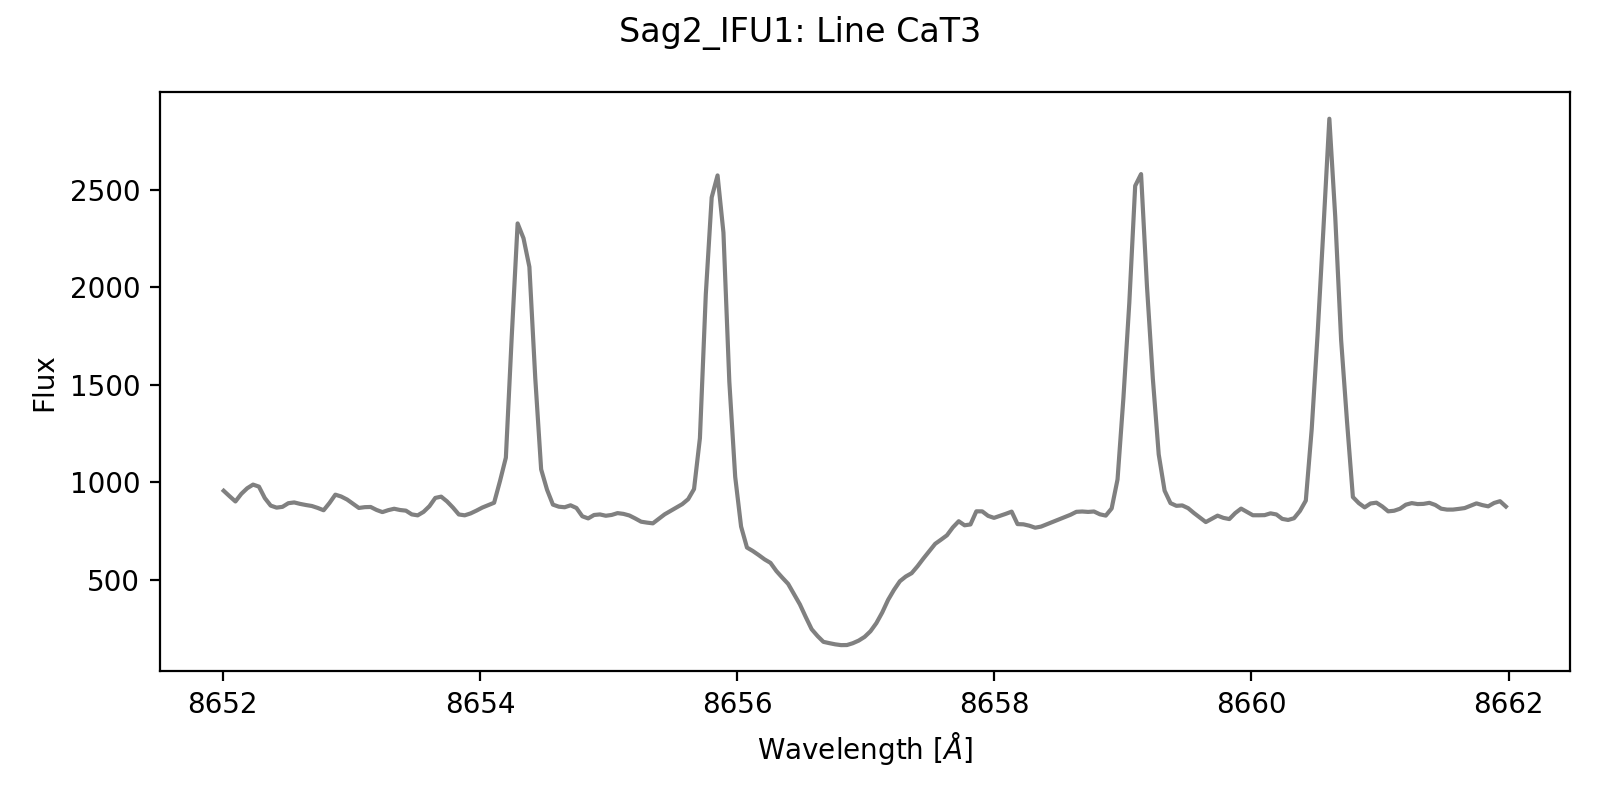

In [277]:
dat = pd.DataFrame()
dat['wavelength_{}'.format(LineName)] = [wavelength_Line]

#---------------------
window_low = 8652 # CHANGE ME: 8490, 8535, 8655
window_up = 8662  # CHANGE ME: 8500, 8545, 8665 
window = np.where( (w >= window_low) & (w <= window_up) )[0]

dat['window_low'] = window_low
dat['window_up'] = window_up

#--------------------- Extract the window around the line 
wind_w = w[window]
wind_f = f[window] 
wind_e = e[window] 

#--------------------- Make a figure 
fig_testPlot = plt.figure(figsize=(8, 4))
plt.suptitle('{}: Line {}'.format(star, LineName))

ax1 = plt.subplot(111)
plt.ylabel('Flux')
plt.xlabel('Wavelength [$\AA$]')
plt.plot(wind_w, wind_f, zorder=1, color='grey', alpha=1)
plt.tight_layout()
plt.savefig(savePath+'{}.png'.format(LineName), dpi=200)

warning: The flux cannot be inf or nan anywhere in this region 

Continue on ...

### Continuum normalize and fit a Lorentz profile to the spectrum 

- JG: I did not continuum normalize my entire spectrum before this. So instead I normalize the region around the line



- A Lorentz profile is fit to the spectral line.  This is to determine the wavelength of the peak which can be used to calculate radial velocity.  Otherwise, the Lorentz profile is only used for visualization purposes.




- JG: My data had many spikes (emission lines or cosmic rays, etc).  You do not want to include these in your integration. So, I added a bit of code to 'chop off' anything above a certain threshold. 

In [278]:
#--------------------- Continuum Normalize within that window
smooth_kernel = 200 # CHANGE ME
sigma_lower = 1 # CHANGE ME
sigma_upper =  1.5 # CHANGE ME
norm, filt = sa.contnorm_2stage(wind_f, smooth_kernel, sigma_lower, sigma_upper)

dat['{}_smooth_kernel'.format(LineName)] = smooth_kernel
dat['{}_sigma_lower'.format(LineName)] = sigma_lower
dat['{}_sigma_upper'.format(LineName)] = sigma_upper

# ----- If your spectrum is already cont. normalized: then comment out the above and uncomment the below line 
# norm = wind_f

#--------------------- Chop spikes off
'''
Your data may have spikes (emission lines or cosmic rays, etc).  
You do not want to include these in your integration. 
So, I added a bit of code to 'chop off' anything above a certain threshold. 

If you do not want to do this set threshold = 1e99 or some other high number 

TODO: Improve the removal of spikes 
'''
threshold = 1.03 # CHANGE ME
inds = np.where(norm >= threshold)[0]
norm[inds] = threshold
wind_e[inds] = 1e99 # of you chop off the spikes, the uncertainty of these points needs to be high 

dat['{}_threshold'.format(LineName)] = threshold

#--------------------- Fit a Laurentzian to the spectrum in this window
ffit_l = curve_fit(lp.Lorentz, wind_w, norm, p0=(0.5, wavelength_Line, 0.5), sigma=wind_e)
afit_l, bfit_l, cfit_l = ffit_l[0]

dat['{}_afit_l'.format(LineName)] = afit_l
dat['{}_bfit_l'.format(LineName)] = bfit_l
dat['{}_cfit_l'.format(LineName)] = afit_l

# ------ Extract the standard error from the fit (gives an array of SE for each parameter)
da_l, db_l, dc_l  = np.sqrt(np.diag(ffit_l[1]))

dat['{}_da_l'.format(LineName)] = da_l
dat['{}_db_l'.format(LineName)] = db_l
dat['{}_dc_l'.format(LineName)] = dc_l


<IPython.core.display.Javascript object>


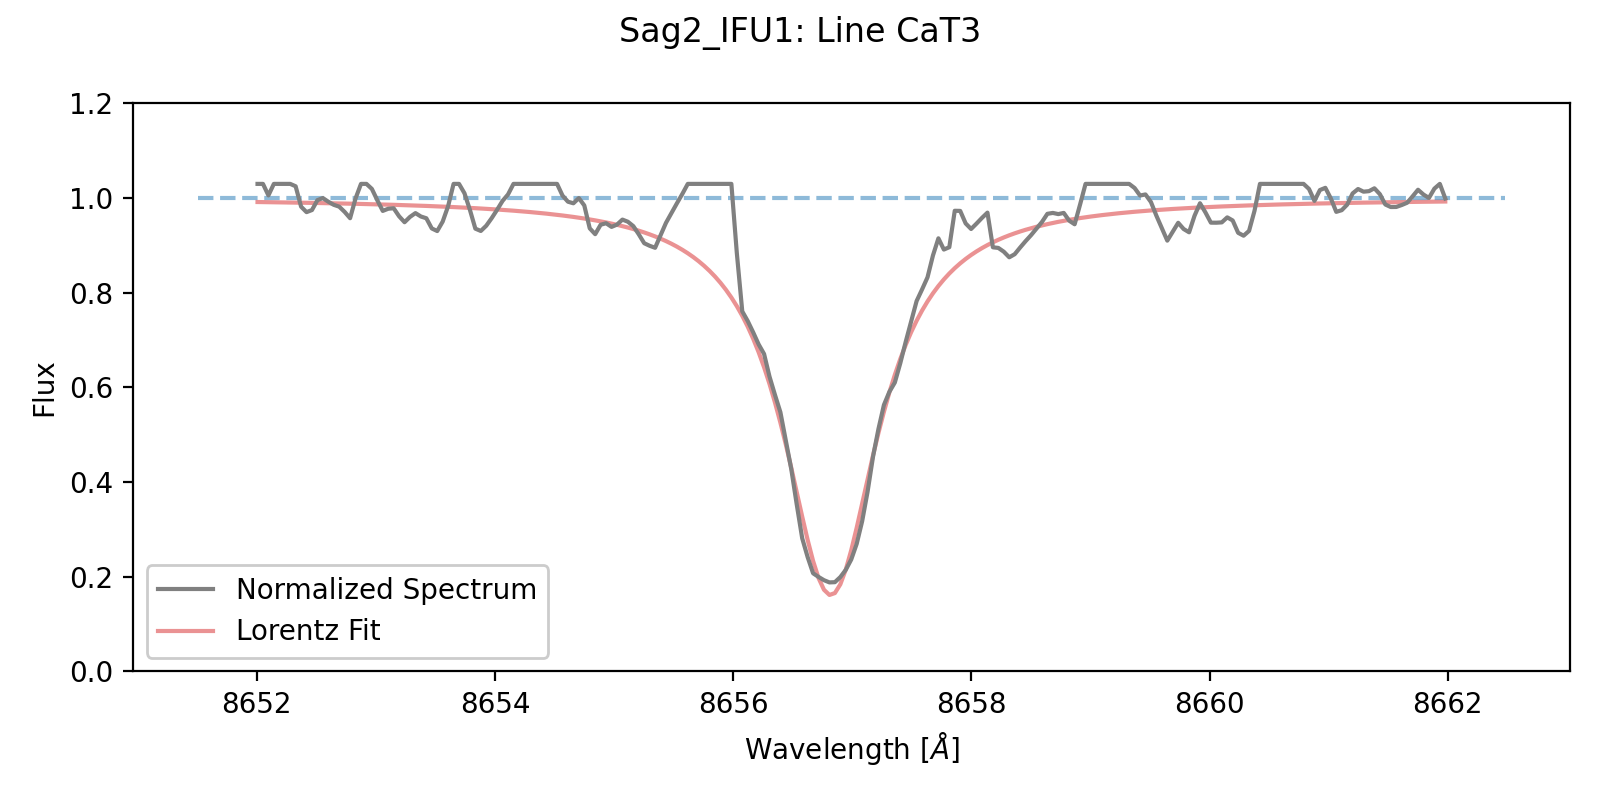

In [279]:
#--------------------- Make a figure 
fig = plt.figure(figsize=(8, 4))
plt.suptitle('{}: Line {}'.format(star, LineName))


ax1 = plt.subplot(111)
plt.ylabel('Flux')
plt.xlabel('Wavelength [$\AA$]')
plt.plot(wind_w, norm, zorder=1, color='grey', alpha=1, label='Normalized Spectrum')

plt.plot(wind_w, lp.Lorentz(wind_w, afit_l, bfit_l, cfit_l ), zorder=0, color='tab:red',alpha=0.5, label='Lorentz Fit')


xmin, xmax = ax1.get_xlim()
plt.hlines(1, xmin, xmax, linestyle='--', zorder=0, alpha=0.5)

plt.ylim(0,1.2)
plt.legend(loc='lower left', framealpha=1)

plt.tight_layout()

plt.savefig(savePath+'{}_LorentzFit.png'.format(LineName), dpi=200)

The peak of the Lorentz fit should correspond with the peal of the spectral line.

The wavelength of the peak of the Lorentz fit is used to calculate the radial velocity 

In [280]:
#--------------------- Calculate RV from this line 
rv = ((bfit_l - wavelength_Line)/wavelength_Line * const.c).to('km/s')

dat['{}_rv[km/s]'.format(LineName)] = rv.to('km/s')

rv

<Quantity -179.30755453 km / s>

### Systematics Plots

The EW of the spectral line is taken to be the area under a *line* minus the area under the spectrum within some range of integration.  
The *line* is a straight line drawn between two end points of integration.  The end points are randomly drawn from a specified range.  


Before the EW calculation, resonable limits must be chosen for the range from which the end points of integration can be drawn.  

The systematics plots help with this.  


1. A hisogram of flux: The standard deviation from the mean will give an estimation of the noise 
2. Varying end points: The EW integration is performed by varying the placement of the end points of integration from very close to the line to far out.  A good location for the end points should be around where the line is flat. 
    - You do not want to integrate over too small range such that some flux is not counted 
    - You do not want to integrate over too large a range such that flux from other spectral lines / noise is counted 

<IPython.core.display.Javascript object>


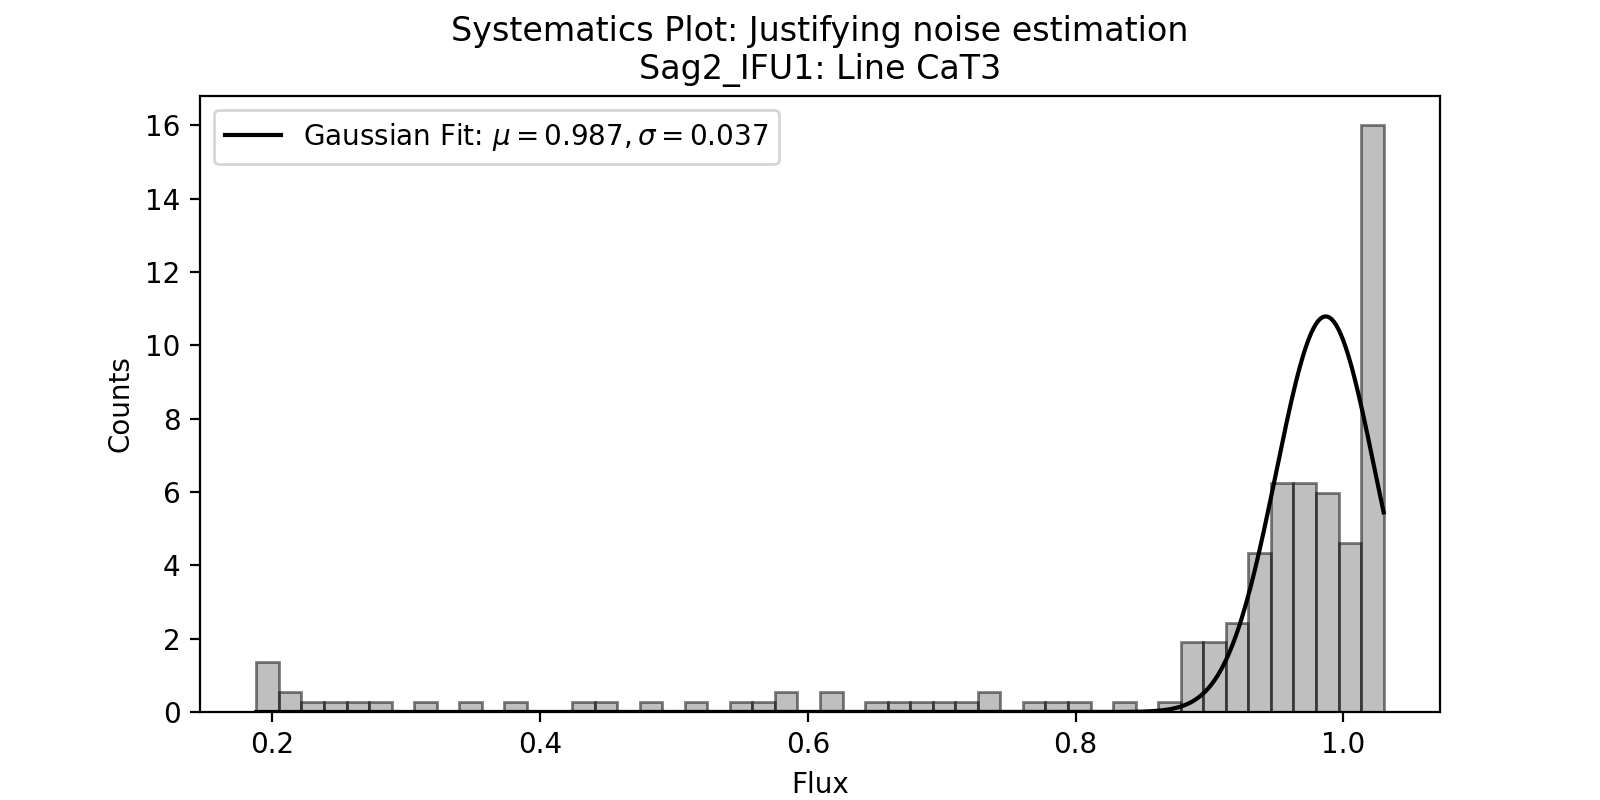

<IPython.core.display.Javascript object>


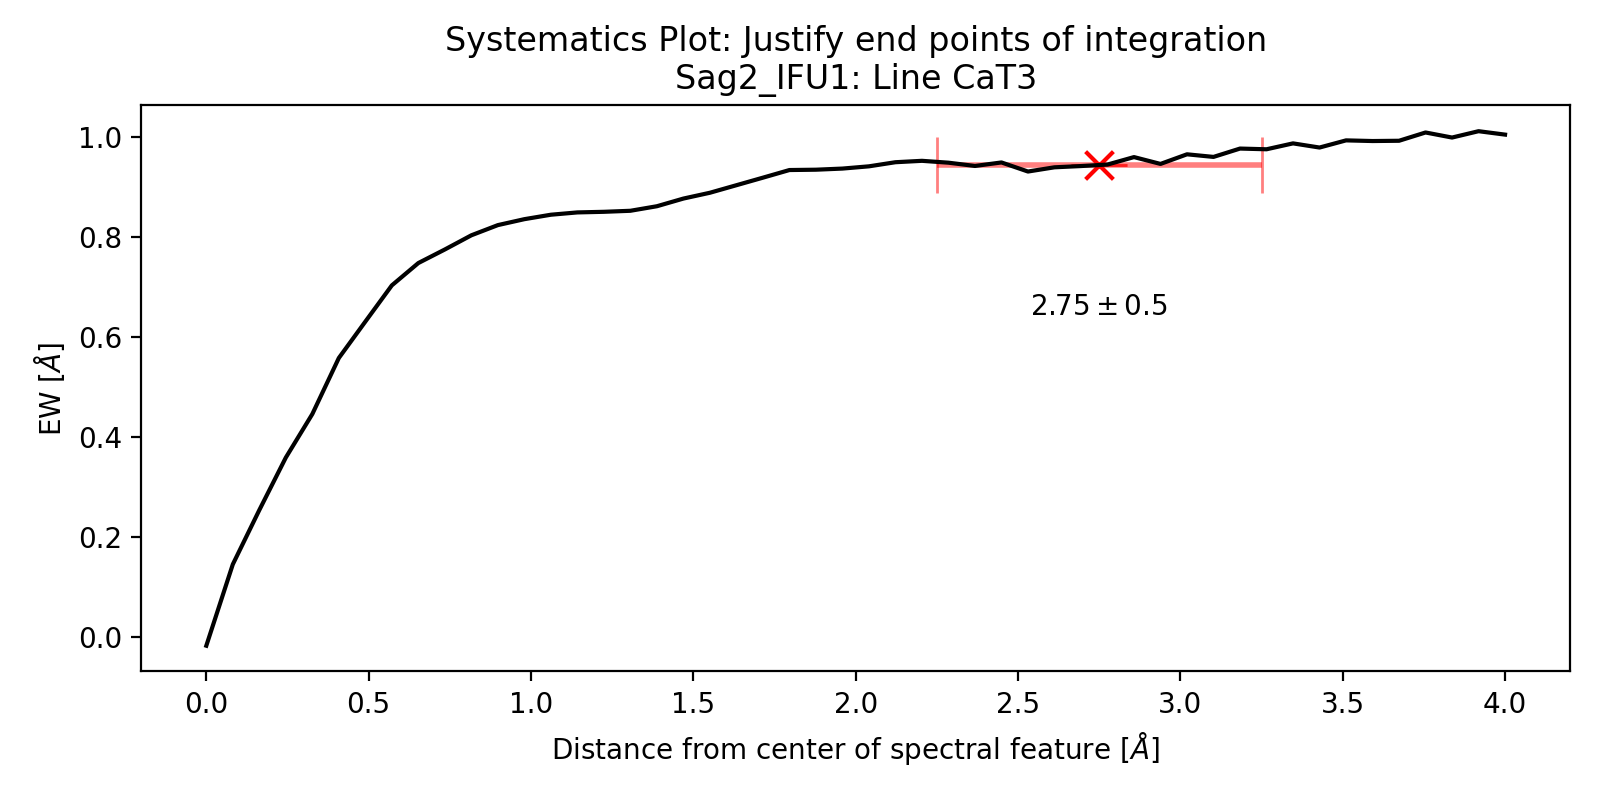

In [281]:
plt.figure(figsize=(8,4))

plt.title('Systematics Plot: Justifying noise estimation'+'\n{}: Line {}'.format(star,LineName))

i = np.where( (norm>= 0.9) & (norm <= 1.1) )[0]
_, bins, _ = plt.hist(norm, 50, density=1, edgecolor="black", color='grey', alpha=0.5)

mu, sigma = scipy.stats.norm.fit(norm[i])
x = np.linspace(min(bins),max(bins), 500)
best_fit_line = scipy.stats.norm.pdf(x, mu, sigma)

plt.plot(x, best_fit_line, label=r'Gaussian Fit: $\mu = {:.3f}, \sigma = {:.3f}$'.format(mu, sigma), color='k')
plt.legend()
plt.xlabel('Flux')
plt.ylabel('Counts')

plt.savefig(savePath+'{}_systematicsNoise.png'.format(LineName), dpi=200)

# -----------------------------------
syst_A, syst_dist = systematics_MC(wind_w,norm,bfit_l,0.5,0.05,  diff_max=4, N = 100)

fig_systIntRange = plt.figure(figsize=(8,4))
ax = plt.subplot(111)

plt.title('Systematics Plot: Justify end points of integration'+'\n{}: Line {}'.format(star, LineName))
plt.plot(syst_dist, syst_A, color='k')

plt.xlabel('Distance from center of spectral feature [$\AA$]')
plt.ylabel('EW [$\AA$]')

plt.tight_layout()

In [282]:
#------------------- Choose Values 
diff = 2.75 # CHANGE ME.  How far away from the peak of the spectral feature to integrate to 
delta_w = 1 # CHANGE ME.  The uncertainty in this position 
delta_f = 0.12 # CHANGE ME. The uncertainty in the continuum (an estimation of the noise)

dat['{}_diff'.format(LineName)] = diff
dat['{}_delta_w'.format(LineName)] = delta_w
dat['{}_delta_f'.format(LineName)] = delta_f

#------------------- Update plot fig_systIntRange
plt.figure(fig_systIntRange)

func = interp1d(syst_dist, syst_A)
plt.errorbar(diff, func(diff), xerr=delta_w/2, yerr=0, color='red', linewidth=2, zorder=0, alpha=0.5, capsize=10)
plt.scatter(diff, func(diff),marker='x',color='red',alpha=1,zorder=1,s=100)

plt.text(diff, func(diff)-0.3*func(diff), r'${} \pm {}$'.format(diff, delta_w/2), verticalalignment='center', horizontalalignment='center') 

plt.savefig(savePath+'{}_systematicsIntRange.png'.format(LineName), dpi=200)

<IPython.core.display.Javascript object>


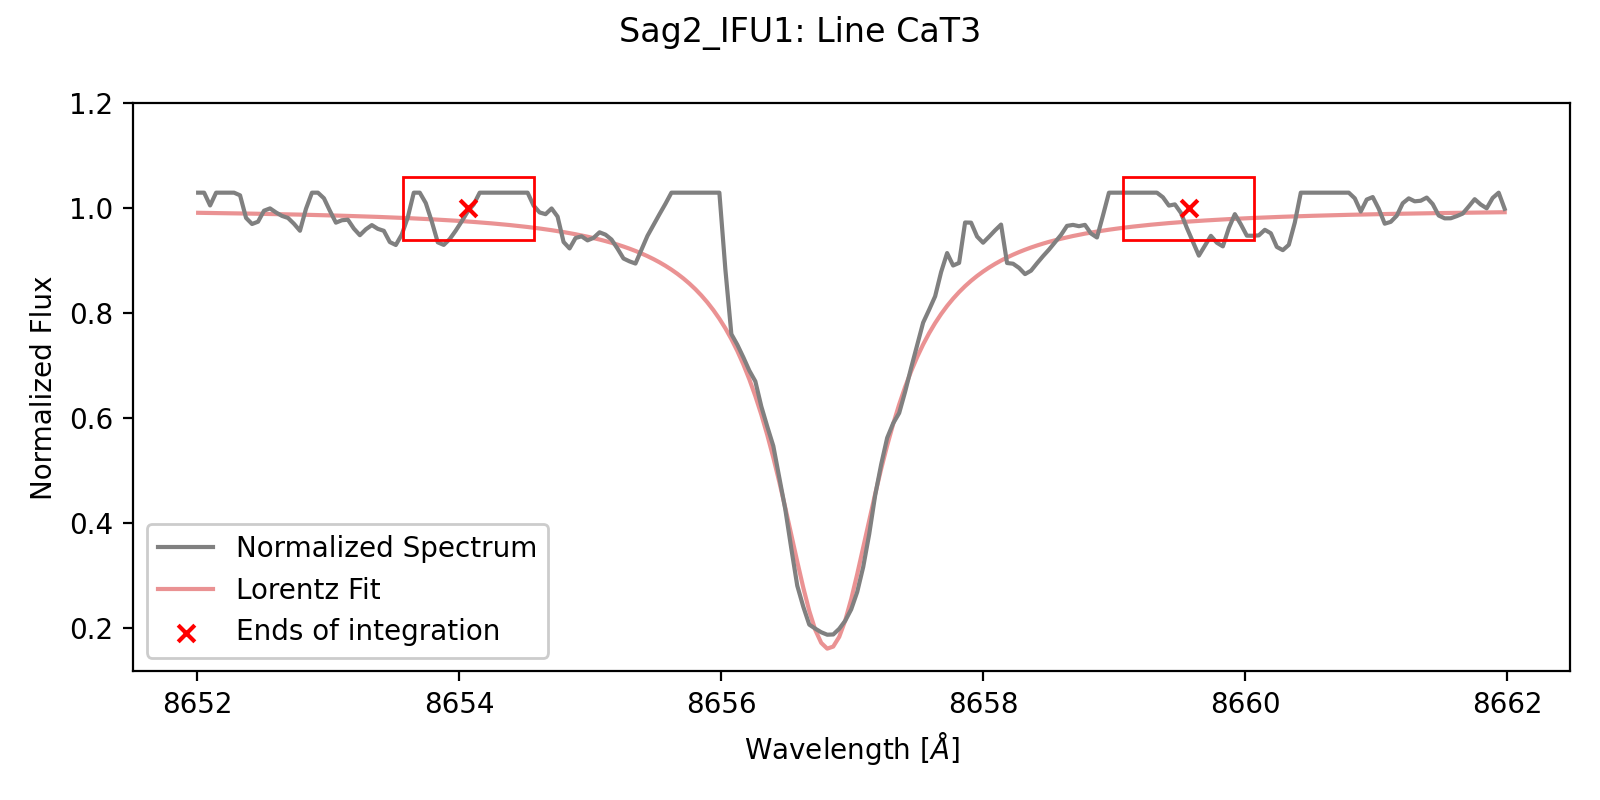

In [283]:
#--------------------- Make a figure 
fig = plt.figure(figsize=(8, 4))
plt.suptitle('{}: Line {}'.format(star, LineName))

ax1 = plt.subplot(111)
plt.ylabel('Normalized Flux')
plt.xlabel('Wavelength [$\AA$]')
plt.plot(wind_w, norm, zorder=1, color='grey', alpha=1, label='Normalized Spectrum')

plt.plot(wind_w, lp.Lorentz(wind_w, afit_l, bfit_l, cfit_l ), zorder=0, color='tab:red',alpha=0.5, label='Lorentz Fit')

ymin, ymax = ax1.get_ylim()
plt.ylim(ymin,1.2)

plt.tight_layout()

# ---- Ends of line profile 
a = bfit_l - diff
b = bfit_l + diff

ax1.scatter(a, 1, color='red', marker='x', label='Ends of integration')
ax1.scatter(b, 1, color='red', marker='x')
plt.legend(loc='lower left', framealpha=1)

# ---- Add boxes with width delta w, delta f
rec = Rectangle( (a - delta_w/2, 1 - delta_f/2) , delta_w, delta_f, facecolor=None, color='red', fill=False)
ax1.add_patch(rec)

rec = Rectangle( (b - delta_w/2, 1 - delta_f/2) , delta_w, delta_f, facecolor=None, color='red', fill=False)
ax1.add_patch(rec)

plt.savefig(savePath+'{}_spectrumIntRange.png'.format(LineName), dpi=200)

End points of integration will be randomly chosen from within the red boxes.

### Calculate EW with the MC Method

<IPython.core.display.Javascript object>


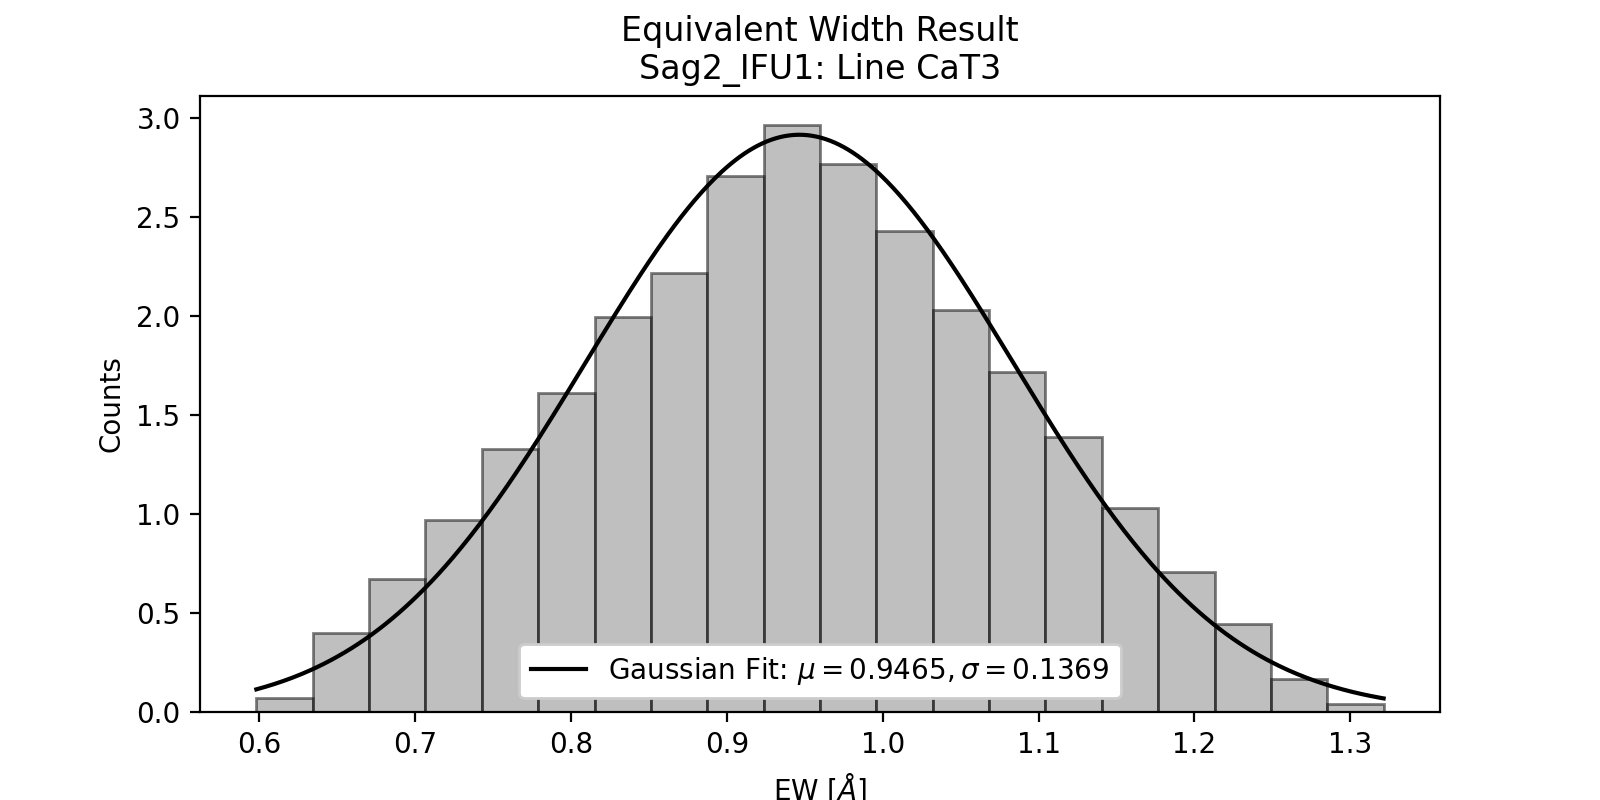

In [285]:
N = 10000 # CHANGE ME.  The number of times to calculate EW.  This shoudl be high 
dat['{}_N'.format(LineName)] = N

A_sample = calculateEW_mc(wind_w,norm,a,b,delta_w, delta_f, N=N)

# --------------------- Plot histogram of EW results
plt.figure(figsize=(8,4))
plt.title('Equivalent Width Result'+'\n{}: Line {}'.format(star, LineName))

_, bins, _ = plt.hist(A_sample, density=1, bins=20,edgecolor="black", color='grey', alpha=0.5)

mu, sigma = scipy.stats.norm.fit(A_sample)

x = np.linspace(min(bins),max(bins), 500)

best_fit_line = scipy.stats.norm.pdf(x, mu, sigma)

plt.plot(x, best_fit_line, label=r'Gaussian Fit: $\mu = {:.4f}, \sigma = {:.4f}$'.format(mu, sigma), color='k')
plt.legend(facecolor='white',framealpha=1,loc='lower center')
plt.ylabel('Counts')
plt.xlabel('EW [$\AA$]')

plt.savefig(savePath+'{}_EWhistogram.png'.format(LineName), dpi=200)

# ------------------
EW = mu
EW_err = sigma

dat['Name{}_EW'.format(LineName)] = EW
dat['Name{}_EW_err'.format(LineName)] = EW_err

dat.to_csv(savePath+'{}_data.csv'.format(LineName))

The mean value of the Gaussian fit is the EW and the uncertainty is the standard deviation

**For comparision, if you integrated the fitted Lorentz profile in the same way what would you get**
- You should get very similar answers if the signal to noise is good 
- The following result is not saved

In [267]:
compare = calculateEW_mc( wind_w, lp.Lorentz(wind_w, afit_l, bfit_l, cfit_l), a,b,delta_w, delta_f, N=N)

np.mean(compare), np.std(compare)

(1.1298712740274746, 0.1356497784790483)